<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/Ensemble_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn

from google.colab import files
files.upload()  # Upload your kaggle.json file

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [3]:
# ========================
# 🧠 Ensemble Cancer Classifier
# EfficientNetB0 + EfficientNetV2B0
# ========================

# 1. Imports
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 2. Constants
DATASET_PATH = "OvarianCancer"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
CLASSES = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {name: idx for idx, name in enumerate(CLASSES)}

# 3. Load and preprocess dataset
X, y = [], []

for class_name in CLASSES:
    class_dir = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(class_dir):
        continue
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)
        X.append(img)
        y.append(class_mapping[class_name])

X = np.array(X)
y = to_categorical(y, num_classes=len(CLASSES))

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

# 6. Input Layer
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# 7. EfficientNetB0 Branch
effnet_b0 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in effnet_b0.layers[:-10]:
    layer.trainable = False
b0_features = effnet_b0(input_layer)
b0_features = GlobalAveragePooling2D()(b0_features)

# 8. EfficientNetV2B0 Branch
effnet_v2b0 = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in effnet_v2b0.layers[:-10]:
    layer.trainable = False
v2b0_features = effnet_v2b0(input_layer)
v2b0_features = GlobalAveragePooling2D()(v2b0_features)

# 9. Merge + Classification Head
merged = Concatenate()([b0_features, v2b0_features])
merged = BatchNormalization()(merged)
merged = Dropout(0.3)(merged)
merged = Dense(512, activation='relu')(merged)
merged = Dropout(0.3)(merged)
output_layer = Dense(len(CLASSES), activation='softmax')(merged)

# 10. Final Model
model = Model(inputs=input_layer, outputs=output_layer)

# 11. Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 12. Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# 13. Train the Model
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=[early_stop, lr_scheduler]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.4138 - loss: 2.0929 - val_accuracy: 0.6300 - val_loss: 0.9677 - learning_rate: 0.0010
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 101s 8s/step - accuracy: 0.7633 - loss: 0.9525 - val_accuracy: 0.6600 - val_loss: 0.8554 - learning_rate: 0.0010
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 79s 6s/step - accuracy: 0.7962 - loss: 0.7037 - val_accuracy: 0.7400 - val_loss: 0.7594 - learning_rate: 0.0010
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.8107 - loss: 0.5937 - val_accuracy: 0.6400 - val_loss: 0.9715 - learning_rate: 0.0010
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 0.8582 - loss: 0.6348 - val_accuracy: 0.7500 - val_loss: 0.7422 - learning_rate: 0.0010
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 0.9017 - loss: 0.3313 - val_accuracy: 0.6900 - val_loss: 0.8868 - learning_rate: 0.0010
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.8901 - loss: 0.3421 - val_accuracy

In [6]:
from sklearn.metrics import accuracy_score
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Test Accuracy:", accuracy_score(y_true_classes, y_pred_classes))


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step
Test Accuracy: 0.81


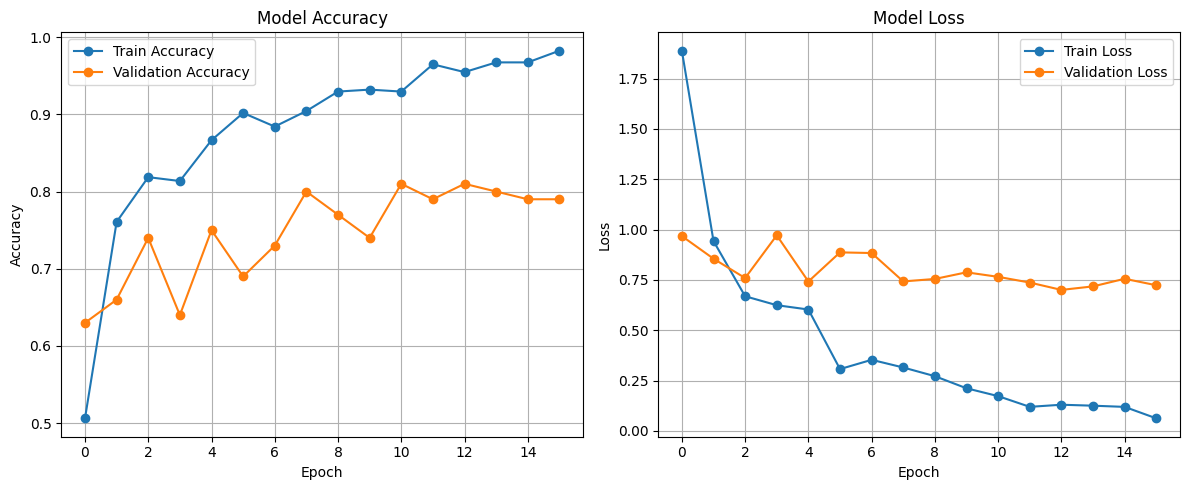

In [4]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


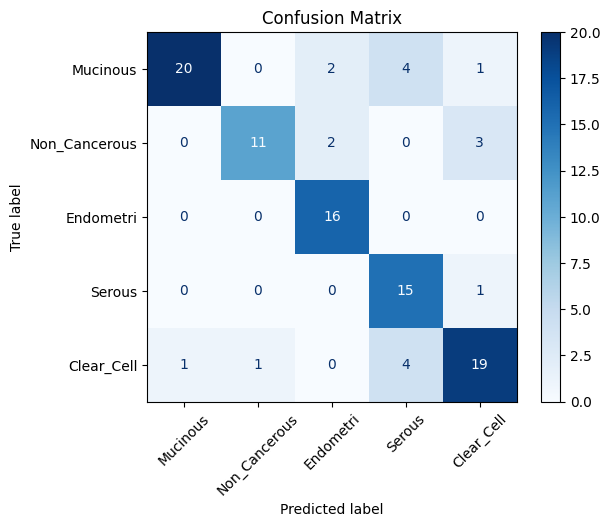

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()
